# Batch Normalization:Accelerating Deep Network Training by Reducing Internal Covariate Shift
# 批处理规范化:通过减少内部协变量移位来加速深度网络训练

# Abstract
# 摘要

Training Deep Neural Networks is complicated by the fact that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs. Our method draws its strength from making normalization a part of the model architecture and performing the  normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout. Applied to a state-of-the-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. Using an ensemble of batchnormalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of human raters.

批处理归一化:当前一层的参数改变时，每一层的输入分布也会改变，这使得通过减少训练深度神经网络来加速深度网络训练变得复杂。这通过要求较低的学习速率和仔细的参数初始化来降低训练速度，并使得用饱和非线性来训练模型变得非常困难。我们将这种现象称为内部协变量移位，并通过规范化层输入来解决这个问题。我们的方法将规范化作为模型体系结构的一部分，并为每个训练小批执行规范化，从而获得了它的优势。批处理规范化允许我们使用更高的学习速率，并且在初始化时不用那么小心。它还作为一个正则化，在某些情况下消除了Dropout的需要。应用于最先进的图像分类模型，Batch Normalization以少14倍的训练步骤达到了同样的精度，并在很大程度上超过了原始模型。使用batchnormalize网络集成模型，我们改进了在ImageNet分类上发表的最佳结果:达到4.9%的top 5 validation error(和4.8% test error)，超过了人类评定者的准确率。

# 1 Introduction
# 1 介绍

Deep learning has dramatically advanced the state of the art in vision, speech, and many other areas. Stochastic gradient descent (SGD) has proved to be an effective way of training deep networks, and SGD variants such as momentum (Sutskever et al., 2013) and Adagrad (Duchi et al., 2011) have been used to achieve state of the art performance. SGD optimizes the parameters Θ of the network, so as to minimize the loss

深度学习极大地提高了视觉、语音和许多其他领域的SOTA。随机梯度下降(SGD)已被证明是一种有效的训练深度网络的方法，SGD变体如momentum (Sutskever et al.， 2013)和Adagrad (Duchi et al.， 2011)已被用来实现最先进的性能状态。SGD网络优化参数Θ,以减少损失

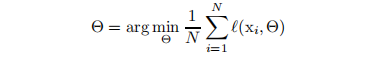

where x1...N is the training data set. With SGD, the training proceeds in steps, and at each step we consider a minibatch x1...m of size m. The mini-batch is used to approximate the gradient of the loss function with respect to the parameters, by computing

x1...N是训练数据集。使用SGD，训练按步骤进行，每一步我们考虑一个minibatch x1...m。通过计算，用小批量近似损失函数相对于参数的梯度

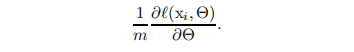


Using mini-batches of examples, as opposed to one example at a time, is helpful in several ways. First, the gradient of the loss over a mini-batch is an estimate of the gradient over the training set, whose quality improves as the batch size increases. Second, computation over a batch can be much more efficient than m computations for individual examples, due to the parallelism afforded by the modern computing platforms.

使用小批量的例子，而不是一次一个例子，在很多方面都是有帮助的。首先，小批处理上的损失梯度是对训练集的梯度的估计，训练集的质量随着Batch大小的增加而提高。其次，由于现代计算平台提供的并行性，Batch的计算可能比单个示例的m计算更有效。

While stochastic gradient is simple and effective, it requires careful tuning of the model hyper-parameters, specifically the learning rate used in optimization, as well as the initial values for the model parameters. The training is complicated by the fact that the inputs to each layer are affected by the parameters of all preceding layers – so that small changes to the network parameters amplify as the network becomes deeper.

虽然随机梯度法简单有效，但它需要对模型超参数进行仔细的调整，特别是用于优化的学习率，以及模型参数的初始值。由于每个层的输入都受到所有前一层的参数的影响，因此，随着网络变得更深，对网络参数的微小变化也会被放大，这使得训练变得更加复杂。

The change in the distributions of layers’ inputs presents a problem because the layers need to continuously adapt to the new distribution. When the input distribution to a learning system changes, it is said to experience covariate shift (Shimodaira, 2000). This is typically handled via domain adaptation (Jiang, 2008). However, the notion of covariate shift can be extended beyond the learning system as a whole, to apply to its parts, such as a sub-network or a layer. Consider a network computing

层的输入分布的变化带来了一个问题，因为层需要不断地适应新的分布。当一个学习系统的输入分布发生变化时，它被称为经历了协变量移位(Shimodaira, 2000)。这通常是通过域适应来处理的(Jiang, 2008)。然而，协变量移位的概念可以扩展到整个学习系统之外，应用到它的各个部分，例如子网络或层。考虑一个网络计算

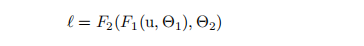

where F1 and F2 are arbitrary transformations, and the parameters Θ1, Θ2 are to be learned so as to minimize the loss ℓ. Learning Θ2 can be viewed as if the inputs x = F1(u, Θ1) are fed into the sub-network

F1和F2任意转换,可以学到和参数Θ1Θ2ℓ以减少损失。学习Θ2可以被视为如果输入x = F1 (u,Θ1)被送入子

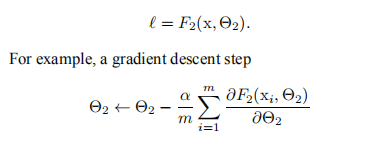

(for batch size m and learning rate α) is exactly equivalent to that for a stand-alone network F2 with input x. Therefore, the input distribution properties that make training more efficient – such as having the same distribution between the training and test data – apply to training the sub-network as well. As such it is advantageous for the distribution of x to remain fixed over time. Then, Θ2 does not have to readjust to compensate for the change in the distribution of x.

(批量大小m和学习速率α)是完全等价的,对于一个独立的网络F2输入x。因此,输入分配属性,使训练更有效,如有相同的分布之间的训练和测试数据,也适用于子网络。因此，随着时间的推移，x的分布保持固定是有利的。然后,Θ2不必调整来弥补x的分布的变化。

Fixed distribution of inputs to a sub-network would have positive consequences for the layers outside the subnetwork, as well. Consider a layer with a sigmoid activation function z = g(Wu + b) where u is the layer input, the weight matrix W and bias vector b are the layer parameters to be learned, and g(x) = 1/1+exp(-x) . As |x| increases, g′(x) tends to zero. This means that for all dimensions of x = Wu+b except those with small absolute values, the gradient flowing down to u will vanish and the model will train slowly. However, since x is affected by W, b and the parameters of all the layers below, changes to those parameters during training will likely move many dimensions of x into the saturated regime of the nonlinearity and slow down the convergence. This effect is amplified as the network depth increases. In practice, the saturation problem and the resulting vanishing gradients are usually addressed by using Rectified Linear Units (Nair & Hinton, 2010) ReLU(x) = max(x, 0), careful initialization (Bengio & Glorot, 2010; Saxe et al., 2013), and small learning rates. If, however, we could ensure that the distribution of nonlinearity inputs remains more stable as the network trains, then the optimizer would be less likely to get stuck in the saturated regime, and the training would accelerate.

对于子网络的输入的固定分布也会对子网外部的层产生积极的影响。考虑一个sigmoid激活函数z = g(Wu + b)的层，其中u为层输入，权矩阵W和偏置向量b为待学习的层参数，g(x) = 1/1+exp(-x)。随着|x|的增加，g'(x)趋于0。这意味着对于x = Wu+b的所有维度，除了那些绝对值较小的维度，流向u的梯度将消失，模型将缓慢训练。但是，由于x受W、b及以下各层参数的影响，在训练过程中，这些参数的变化可能会使x的多个维度进入非线性饱和状态，从而减慢收敛速度。这种效应随着网络深度的增加而增强。在实践中，饱和问题和由此产生的消失梯度通常通过使用修正的线性单元(Nair & Hinton, 2010) ReLU(x) = max(x, 0)，仔细初始化(Bengio & Glorot, 2010;(Saxe et al.， 2013)，和小的学习率。然而，如果我们可以确保非线性输入的分布在网络训练时保持更稳定，那么优化器就不太可能陷入饱和状态，训练就会加速。

We refer to the change in the distributions of internal nodes of a deep network, in the course of training, as Internal Covariate Shift. Eliminating it offers a promise of faster training. We propose a new mechanism, which we call Batch Normalization, that takes a step towards reducing internal covariate shift, and in doing so dramatically accelerates the training of deep neural nets. It accomplishes this via a normalization step that fixes the means and variances of layer inputs. Batch Normalization also has a beneficial effect on the gradient flow through the network, by reducing the dependence of gradients on the scale of the parameters or of their initial values. This allows us to use much higher learning rates without the risk of divergence. Furthermore, batch normalization regularizes the model and reduces the need for Dropout (Srivastava et al., 2014). Finally, Batch Normalization makes it possible to use saturating nonlinearities by preventing the network from getting stuck in the saturated modes.

在训练过程中，我们将深层网络内部节点分布的变化称为内部协变量移位。消除它可以提供更快的训练。我们提出了一种新的机制，我们称之为Batch Normalization，它向减少内部协变量移位迈出了一步，并在此过程中极大地加速了深度神经网络的训练。它通过固定层输入的方法和方差的标准化步骤来实现这一点。Batch Normalization还对通过网络的梯度流有有益的影响，因为它减少了梯度对参数或其初始值的依赖。这使我们能够使用更高的学习率，而不存在出现分歧的风险。此外，Batch Normalization使模型规范化，减少了Dropout的需要(Srivastava et al.， 2014)。最后，批处理规范化通过防止网络陷入饱和模式，使得使用饱和非线性成为可能。

In Sec. 4.2, we apply Batch Normalization to the best performing ImageNet classification network, and show that we can match its performance using only 7% of the training steps, and can further exceed its accuracy by a substantial margin. Using an ensemble of such networks trained with Batch Normalization, we achieve the top-5 error rate that improves upon the best known results on ImageNet classification.

在第4.2节中，我们将批处理归一化应用到性能最好的ImageNet分类网络中，结果表明，我们只需使用7%的训练步骤就可以匹配它的性能，并且可以大大超出它的精度。通过使用Batch Normalization训练的网络集合，我们实现了排名前5的错误率，提高了ImageNet分类的最佳结果。








# 2 Towards Reducing Internal Covariate Shift
# 2 减少内部协变量移位

We define Internal Covariate Shift as the change in the distribution of network activations due to the change in network parameters during training. To improve the training, we seek to reduce the internal covariate shift. By fixing the distribution of the layer inputs x as the training progresses, we expect to improve the training speed. It has been long known (LeCun et al., 1998b; Wiesler & Ney, 2011) that the network training converges faster if its inputs are whitened – i.e., linearly transformed to have zero means and unit variances, and decorrelated. As each layer observes the inputs produced by the layers below, it would be advantageous to achieve the same whitening of the inputs of each layer. By whitening the inputs to each layer, we would take a step towards achieving the fixed distributions of inputs that would remove the ill effects of the internal covariate shift.

我们将内部协变位移定义为训练过程中由于网络参数的变化而引起的网络活动分布的变化。为了提高训练质量，我们试图减少内部协变量移位。随着训练的进行，通过固定层输入x的分布，我们期望提高训练速度。这早已为人所知(LeCun et al.， 1998b;Wiesler & Ney(2011)认为，如果网络的输入被加白，那么网络训练的收敛速度会更快。，线性变换为均值和单位方差为零，去相关。由于每一层都观察到下面各层所产生的输入，因此对每一层的输入进行相同的增白将是有利的。通过对每一层的输入进行增白，我们将朝着实现输入的固定分布迈出一步，从而消除内部协变量移位的不良影响。

We could consider whitening activations at every training step or at some interval, either by modifying the network directly or by changing the parameters of the optimization algorithm to depend on the network activation values (Wiesler et al., 2014; Raiko et al., 2012; Povey et al., 2014; Desjardins & Kavukcuoglu). However, if these modifications are interspersed with the optimization steps, then the gradient descent step may attempt to update the parameters in a way that requires the normalization to be updated, which reduces the effect of the gradient step. For example, consider a layer with the input u that adds the learned bias b, and normalizes the result by subtracting the mean of the activation computed over the training data: xb = x E[x] where x = u + b, X = {x1...N } is the set of values of x over the training set, and E[x] = 1/N sigma N i=1 xi. If a gradient descent step ignores the dependence of E[x] on b, then it will update b ← b + ∆b, where ∆b ∝ −∂ℓ/∂x. Then u + (b + ∆b) - E[u + (b + ∆b)] = u + b E[u + b]. Thus, the combination of the update to b and subsequent change in normalization led to no change in the output of the layer nor, consequently, the loss. As the training continues, b will grow indefinitely while the loss remains fixed. This problem can get worse if the normalization not only centers but also scales the activations. We have observed this empirically in initial experiments, where the model blows up when the normalization parameters are computed outside the gradient descent step.

我们可以通过直接修改网络或者根据网络激活值改变优化算法的参数，来考虑在每个训练步骤或在某个区间的美白激活(Wiesler et al.， 2014;雷电子等，2012;Povey et al.， 2014;德斯贾丁斯& Kavukcuoglu)。但是，如果这些修改与优化步骤穿插在一起，那么梯度下降步骤可能会尝试以需要更新规格化的方式更新参数，从而降低梯度步骤的效果。例如，考虑一个带有输入u的层，它添加了学习偏差b，并通过减去训练数据上计算的激活的平均值来将结果正常化:xb = x E[x]，其中x = u + b, x = {x1…N}是x在训练集上的取值集合，E[x] =1 /N∑N i=1 xi。如果忽略了梯度下降法一步依赖b E (x),那么它将更新b←b +∆b, b,∆∝−∂ℓ/∂x。然后u + (b +∆b) - E (u + (b +∆b)) = u + b E (u + b)。因此，对b的更新和随后的标准化更改的组合不会导致层的输出更改，也不会导致损失。随着训练的继续，b将会无限的成长，而损失将会固定。如果标准化不仅集中而且扩展激活，这个问题会变得更糟。在初始实验中，当归一化参数在梯度下降步外计算时，模型会爆炸，我们对此进行了经验观察。

The issue with the above approach is that the gradient descent optimization does not take into account the fact that the normalization takes place. To address this issue, we would like to ensure that, for any parameter values, the network always produces activations with the desired distribution. Doing so would allow the gradient of the loss with respect to the model parameters to account for the normalization, and for its dependence on the model parameters Θ. Let again x be a layer input, treated as a vector, and X be the set of these inputs over the training data set. The normalization can then be written as a transformation

上述方法的问题是，梯度下降优化没有考虑到正常化的事实。为了解决这个问题，我们希望确保对于任何参数值，网络总是生成具有所需分布的激活。这样做会让失去的梯度对模型参数占正常化,Θ和依赖的模型参数。同样，设x是一个层输入，作为一个向量，x是这些输入在训练数据集上的集合，然后可以将标准化写成一个转换

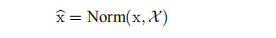

which depends not only on the given training example x but on all examples X – each of which depends on Θ if x is generated by another layer. For backpropagation, we would need to compute the Jacobians

这不仅取决于给定的训练例子但在所有例子x -每个取决于Θ如果x是由另一个层。对于反向传播，我们需要计算雅可比矩阵

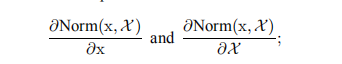

ignoring the latter term would lead to the explosion described above. Within this framework, whitening the layer inputs is expensive, as it requires computing the covariance matrix Cov[x] = Ex∈X [xxT ] E[x]E[x]T and its inverse square root, to produce the whitened activations Cov[x]-1/2(x - E[x]), as well as the derivatives of these transforms for backpropagation. This motivates us to seek an alternative that performs input normalization in a way that is differentiable and does not require the analysis of the entire training set after every parameter update.

忽略后一项将导致上面所述的爆炸。在此框架下，对层输入进行白化是昂贵的，因为需要计算Cov[x] = Ex∈x [xxT]E[x] E[x]T及其逆平方根的协方差矩阵Cov[x] = Ex∈x [x]E[x]T，从而产生白化的激活Cov[x]-1/2(x - E[x])，以及这些变换的导数进行反向传播。这促使我们寻找一种替代方法，以一种可微的方式执行输入规范化，并且不需要在每次更新参数后对整个训练集进行分析。

Some of the previous approaches (e.g. (Lyu & Simoncelli, 2008)) use statistics computed over a single training example, or, in the case of image networks, over different feature maps at a given location. However, this changes the representation ability of a network by discarding the absolute scale of activations. We want to a preserve the information in the network, by normalizing the activations in a training example relative to the statistics of the entire training data.

以前的一些方法(如Lyu和Simoncelli, 2008))使用单个训练示例计算的统计数据，或者，在图像网络的情况下，使用给定位置的不同特征映射计算的统计数据。但是，这将通过丢弃激活的绝对规模来改变网络的表示能力。我们希望通过将训练示例中的激活与整个训练数据的统计数据进行归一化，从而保护网络中的信息。








# 3 Normalization via Mini-Batch Statistics
# 3 .通过小批量统计进行归一化

Since the full whitening of each layer’s inputs is costly and not everywhere differentiable, we make two necessary simplifications. The first is that instead of whitening the features in layer inputs and outputs jointly, we will normalize each scalar feature independently, by making it have the mean of zero and the variance of 1. For a layer with d-dimensional input x = (x(1) . . . x(d)), we will normalize each dimension

由于每一层输入的完全白化是昂贵的，并且不是处处可微的，所以我们做了两个必要的简化。首先，我们不需要联合对层输入和输出中的特征进行白化，而是通过使其均值为0，方差为1来独立地对每个标量特征进行标准化。对于一个层具有d维输入x = (x(1)…x(d)），我们将使每个维度标准化

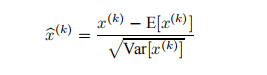

where the expectation and variance are computed over the training data set. As shown in (LeCun et al., 1998b), such normalization speeds up convergence, even when the features are not decorrelated.

如(LeCun et al.， 1998b)所示，即使特征不去相关，这种标准化也能加速收敛。

Note that simply normalizing each input of a layer may change what the layer can represent. For instance, normalizing the inputs of a sigmoid would constrain them to the linear regime of the nonlinearity. To address this, we make sure that the transformation inserted in the network can represent the identity transform. To accomplish this, we introduce, for each activation x(k), a pair of parameters γ(k) , β(k), which scale and shift the normalized value:

注意，简单地规范化一个层的每个输入可能会改变层所能表示的内容。例如，对一个sigmoid的输入进行归一化会将其约束到非线性的线性状态。为了解决这个问题，我们确保插入到网络中的转换可以表示标识转换。为此,我们引入,对于每个激活x (k),一对参数γ(k),β(k),规模和转变归一化值:

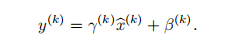

These parameters are learned along with the original model parameters, and restore the representation power of the network. Indeed, by setting γ(k) = The square root of Var[x(k)] and β(k) = E[x(k)], we could recover the original activations, if that were the optimal thing to do.

这些参数与原模型参数一起学习，恢复网络的表示能力。事实上,通过设置γ(k) =根号Var (x (k))和β(k) = E [x (k)],我们可以恢复原来的激活,如果这是最优的事情。

In the batch setting where each training step is based on the entire training set, we would use the whole set to normalize activations. However, this is impractical when using stochastic optimization. Therefore, we make the second simplification: since we use mini-batches in stochastic gradient training, each mini-batch produces estimates of the mean and variance of each activation. This way, the statistics used for normalization can fully participate in the gradient backpropagation. Note that the use of minibatches is enabled by computation of per-dimension variances rather than joint covariances; in the joint case, regularization would be required since the mini-batch size is likely to be smaller than the number of activations being whitened, resulting in singular covariance matrices. 

在批处理设置中，每个训练步骤都基于整个训练集，我们将使用整个训练集来规范化激活。然而，在使用随机优化时，这是不切实际的。因此，我们进行了第二个简化:由于我们在随机梯度训练中使用了小批量，每个小批量生成每个激活的平均值和方差的估计值。这样，用于归一化的统计量可以充分参与梯度反向传播。注意，使用小批量是通过计算每维方差而不是联合协方差来实现的;在联合的情况下，将需要正则化，因为小批处理的大小可能小于正在漂白的激活数，从而导致奇异协方差矩阵。

Consider a mini-batch B of size m. Since the normalization is applied to each activation independently, let us focus on a particular activation x(k) and omit k for clarity. We have m values of this activation in the mini-batch,

考虑一个大小为m的小型批处理B。由于规范化是独立地应用于每个激活的，因此我们将重点放在一个特定的激活x(k)上，为了清楚起见省略k。我们有m个小批量激活的值，

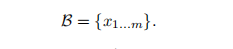

Let the normalized values be x1...m, and their linear transformations be y1...m. We refer to the transform

令规格化后的值为x1…m,它们的线性变换是y1…m。我们指的是变换

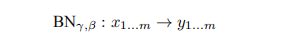

as the Batch Normalizing Transform. We present the BN Transform in Algorithm 1. In the algorithm, ε is a constant added to the mini-batch variance for numerical stability.

作为 Batch Normalizing变换。我们在算法1中给出了BN变换。算法,ε是一个常数添加到mini-batch方差的数值稳定性。

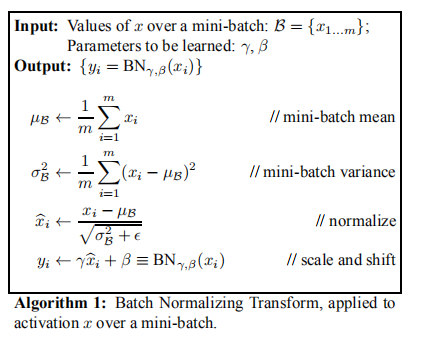

The BN transform can be added to a network to manipulate any activation. In the notation y = BNγ,β(x), we indicate that the parameters γ and β are to be learned, but it should be noted that the BN transform does not independently process the activation in each training example. Rather, BNγ,β(x) depends both on the training example and the other examples in the mini-batch. The scaled and shifted values y are passed to other network layers. The normalized activations xb are internal to our transformation, but their presence is crucial. The distributions of values of any xb has the expected value of 0 and the variance of 1, as long as the elements of each mini-batch are sampled from the same distribution, and if we neglect ǫ. This can be seen by observing that sigma m i=1 xi = 0 and 1/m sigma m i=1 xi^2 = 1, and taking expectations. Each normalized activation xb(k) can be viewed as an input to a sub-network composed of the linear transform y(k) = γ(k)xb(k) + β(k) , followed by the other processing done by the original network. These sub-network inputs all have fixed means and variances, and although the joint distribution of these normalized xb(k) can change over the course of training, we expect that the introduction of normalized inputs accelerates the training of the sub-network and, consequently, the network as a whole.

BN转换可以被添加到网络中来操作任何激活。符号y = BNγ,β(x),我们表明,参数γ和β是需要学习,但应该注意的是,BN变换不独立过程激活在每个训练的例子。BNγ,β(x)都取决于训练例子和mini-batch中的其他例子。缩放和移位的值y被传递到其他网络层。标准化的激活x^是我们转换的内部，但是它们的存在是至关重要的。值的分布的x^的期望值0和1的方差,只要每个mini-batch抽样从相同的元素分布,如果我们忽视ε。这可以通过观察∑m i=1 x^ = 0和1/m ∑m i=1 x² = 1来观察，并取期望值。每个激活x^正常化(k)可以被视为一个输入子组成的线性变换y (k) =γ(k) xb (k) +β(k),其次是其他处理由原来的网络。这些子网络的输入都有固定的均值和方差，尽管这些标准化的xb(k)的联合分布可能在训练过程中发生变化，但我们期望标准化输入的引入能够加速子网络的训练，从而加速整个网络的训练。

During training we need to back propagate the gradient of loss ℓ through this transformation, as well as compute the gradients with respect to the parameters of the BN transform. We use chain rule, as follows (before simplification):

训练期间我们需要反向传播损失ℓ 通过这个变换的梯度,以及计算梯度对BN的参数变换。我们使用链式法则，如下(化简前):

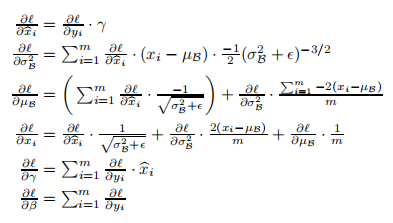

Thus, BN transform is a differentiable transformation that introduces normalized activations into the network. This ensures that as the model is training, layers can continue learning on input distributions that exhibit less internal covariate shift, thus accelerating the training. Furthermore, the learned affine transform applied to these normalized activations allows the BN transform to represent the identity transformation and preserves the network capacity.

因此，BN变换是一个可微变换，它将规范化激活引入到网络中。这确保了在模型进行训练时，层可以继续学习输入分布，这种分布显示较少的内部协变量移位，从而加速了训练。此外，应用于这些标准化激活的学习仿射变换允许BN变换表示身份变换并保留网络容量。

## 3.1 Training and Inference with BatchNormalized Networks
## 3.1批处理规范化网络的训练与推理

To Batch-Normalize a network, we specify a subset of activations and insert the BN transform for each of them, according to Alg. 1. Any layer that previously received x as the input, now receives BN(x). A model employing Batch Normalization can be trained using batch gradient descent, or Stochastic Gradient Descent with a mini-batch size m > 1, or with any of its variants such as Adagrad (Duchi et al., 2011). The normalization of activations that depends on the mini-batch allows efficient training, but is neither necessary nor desirable during inference; we want the output to depend only on the input, deterministically. For this, once the network has been trained, we use the normalization

要对网络进行批处理规范化，我们指定激活的子集，并根据Alg. 1为每个激活插入BN转换。以前接收x作为输入的任何层，现在接收BN(x)。采用批量归一化的模型可以采用批量梯度下降法或小批量m &gt的随机梯度下降法进行训练;或与它的任何变体，如Adagrad (Duchi等人，2011)。依赖于小批处理的激活的规范化允许有效的训练，但在推理期间既没有必要也不可取;我们希望输出只依赖于输入，这是确定的。为此，一旦对网络进行了训练，我们就使用标准化

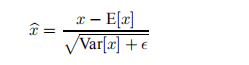


using the population, rather than mini-batch, statistics. Neglecting  , these normalized activations have the same mean 0 and variance 1 as during training. We use the unbiased variance estimate Var[x] = m/m-1 · EB[σ2B], where the expectation is over training mini-batches of size m and σ2B are their sample variances. Using moving averages instead, we can track the accuracy of a model as it trains. Since the means and variances are fixed during inference, the normalization is simply a linear transform applied to each activation. It may further be composed with the scaling by γ and shift by β, to yield a single linear transform that replaces BN(x). Algorithm 2 summarizes the procedure for training batch-normalized networks.

使用总体统计数据，而不是小批量统计数据。忽略后，这些标准化激活的均值0和方差1与训练时相同。我们使用无偏方差估计Var [x] = m / m - 1 EB(σ2B),期望在哪里/训练mini-batches尺寸m和σ2B样本方差。使用移动平均线，我们可以跟踪一个模型的准确性。由于在推理过程中均值和方差是固定的，标准化只是对每个激活应用一个线性变换。可能进一步组成比例由γ和β转变,产生一个线性变换代替BN (x)。算法2总结了批量规范化网络的训练过程。


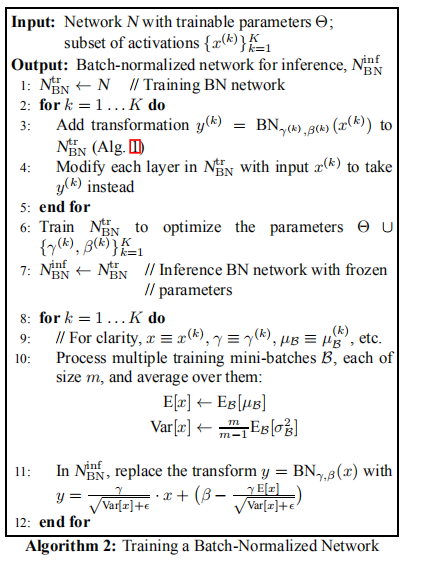


## 3.2 Batch-Normalized Convolutional Networks
## 3.2批量归一化卷积网络

Batch Normalization can be applied to any set of activations in the network. Here, we focus on transforms that consist of an affine transformation followed by an element-wise nonlinearity:

Batch Normalization可以应用于网络中的任何一组激活。这里，我们关注的是由一个仿射变换和一个元素非线性组成的变换:

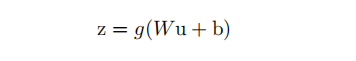

where W and b are learned parameters of the model, and g(·) is the nonlinearity such as sigmoid or ReLU. This formulation covers both fully-connected and convolutional layers. We add the BN transform immediately before the nonlinearity, by normalizing x = Wu+ b. We could have also normalized the layer inputs u, but since u is likely the output of another nonlinearity, the shape of its distribution is likely to change during training, and constraining its first and second moments would not eliminate the covariate shift. In contrast, Wu + b is more likely to have a symmetric, non-sparse distribution, that is “more Gaussian” (Hyv¨arinen & Oja, 2000); normalizing it is likely to produce activations with a stable distribution.

其中W、b为模型的学习参数，g(·)为sigmoid、ReLU等非线性项。这个公式包括全连接层和卷积层。我们立即添加BN变换非线性之前,x = Wu+ b标准化。我们也可以归一化层的输入u,但是因为你可能是另一个非线性的输出,其分布的形状可能会改变在训练,并限制其第一和第二时刻不会消除协变量的转变。相比之下，Wu + b更可能具有对称的、非稀疏的分布，即“更趋于高斯分布”(Hyv¨arinen & Oja, 2000);normalizing可能产生分布稳定的活化。


Note that, since we normalize Wu+b, the bias b can be ignored since its effect will be canceled by the subsequent mean subtraction (the role of the bias is subsumed by β in Alg. 1). Thus, z = g(Wu + b) is replaced with

注意,因为我们规范化 Wu+b, b偏差可以忽略,因为其效果将取消后续的意思是减法(偏见的角色被归入β在Alg。1)。因此,z = g(吴+ b)所取代

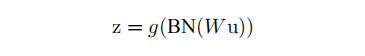


where the BN transform is applied independently to each dimension of x = Wu, with a separate pair of learned parameters γ(k), β(k) per dimension.

BN的变换是独立应用于每个维度的x = Wu,一双单独学习参数γ(k),β每个维度(k)。

For convolutional layers, we additionally want the normalization to obey the convolutional property – so that different elements of the same feature map, at different locations, are normalized in the same way. To achieve this, we jointly normalize all the activations in a minibatch, over all locations. In Alg. 1, we let B be the set of all values in a feature map across both the elements of a mini-batch and spatial locations – so for a mini-batch of size m and feature maps of size p × q, we use the effective mini-batch of size m′ = |B| = m · p q. We learn a pair of parameters γ(k) and β(k) per feature map, rather than per activation. Alg. 2 is modified similarly, so that during inference the BN transform applies the same linear transformation to each activation in a given feature map.

对于卷积层，我们还希望归一化遵循卷积属性——这样，在不同的位置，相同feature map的不同元素就会以相同的方式归一化。为了实现这一点，我们将所有位置上的所有激活在一个minibatch中进行联合规范化。Alg。1,我们让B中所有值的集合特征映射在mini-batch和空间位置的元素,所以mini-batch的尺寸大小的地图p×m和特性,我们使用的有效mini-batch大小m′= |B| = m·pq。我们学习两个参数γ(k)和β(k) /功能映射,而不是每个激活。Alg. 2也进行了类似的修改，以便在推断过程中BN变换对给定特征映射中的每个激活都应用相同的线性变换。

## 3.3 Batch Normalization enables higher learning rates
## 3.3 批量标准化可以提高学习效率

In traditional deep networks, too-high learning rate may result in the gradients that explode or vanish, as well as getting stuck in poor local minima. Batch Normalization helps address these issues. By normalizing activations throughout the network, it prevents small changes to the parameters from amplifying into larger and suboptimal changes in activations in gradients; for instance, it prevents the training from getting stuck in the saturated regimes of nonlinearities.

在传统的深度网络中，过高的学习率可能会导致梯度的爆炸或消失，以及陷入糟糕的局部极小值。Batch Normalization有助于解决这些问题。通过对整个网络的激活进行归一化，它可以防止参数的微小变化放大成梯度激活中较大的次优变化;例如，它可以防止训练陷入非线性的饱和状态。

Batch Normalization also makes training more resilient to the parameter scale. Normally, large learning rates may increase the scale of layer parameters, which then amplify the gradient during backpropagation and lead to the model explosion. However, with Batch Normalization, backpropagation through a layer is unaffected by the scale of its parameters. Indeed, for a scalar a,

Batch Normalization也使训练对参数标度更有弹性。通常情况下，较大的学习率会增大层参数的尺度，进而放大反向传播时的梯度，导致模型爆炸。然而，使用批处理规范化时，通过层的反向传播不受其参数范围的影响。确实，对于标量a，

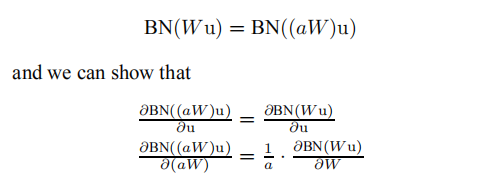

The scale does not affect the layer Jacobian nor, consequently, the gradient propagation. Moreover, larger weights lead to smaller gradients, and Batch Normalization will stabilize the parameter growth.

尺度不影响层的雅可比矩阵，因此也不影响梯度传播。而且，权值越大，梯度越小，Batch Normalization可以稳定参数的增长。

We further conjecture that Batch Normalization may lead the layer Jacobians to have singular values close to 1, which is known to be beneficial for training. Consider two consecutive layers with normalized inputs, and the transformation between these normalized vectors: z^ = F(bx). If we assume that bx and bz are Gaussian and uncorrelated, and that F(bx) ≈ Jbx is a linear transformation for the given model parameters, then both bx and bz have unit covariances, and I = Cov[bz] = JCov[bx]JT = JJT. Thus, JJT = I, and so all singular values of J are equal to 1, which preserves the gradient magnitudes during backpropagation. In reality, the transformation is not linear, and the normalized values are not guaranteed to be Gaussian nor independent, but we nevertheless expect Batch Normalization to help make gradient propagation better behaved. The precise effect of Batch Normalization on gradient propagation remains an area of further study

我们进一步推测，批处理归一化可能导致层雅可比矩阵的奇异值接近1，这对训练是有益的。考虑两个具有标准化输入的连续层，以及这些标准化向量之间的转换:z^ = F(x^)。假设x^与b=z^为高斯非相关，且F(bx)≈Jbx为给定模型参数的线性变换，则bx与bz均有单位协方差，且I = Cov[bz] = JCov[bx]JT = JJT。因此，JJT = I，所以J的所有奇异值都等于1，这样在反向传播时，可以保持梯度大小。在现实中，变换不是线性的，归一化的值不能保证是高斯的，也不能保证是独立的，但是我们期望Batch Normalization能够帮助梯度传播更好的表现。Batch Normalization对梯度传播的精确影响仍是一个有待进一步研究的领域。

## 3.4 Batch Normalization regularizes the model
## 3.4批量归一化对模型进行规范化

When training with Batch Normalization, a training example is seen in conjunction with other examples in the mini-batch, and the training network no longer producing deterministic values for a given training example. In our experiments, we found this effect to be advantageous to the generalization of the network. Whereas Dropout is typically used to reduce over-fitting, in a batch-normalized network we found that it can be either removed or reduced in strength.

当使用Batch Normalization进行训练时，一个训练示例与mini-batch中的其他示例一起出现，训练网络不再为给定的训练示例生成确定性值。在实验中，我们发现这种效应有利于网络的泛化。虽然Dropout通常用于减少过拟合，但在一个批处理规范化的网络中，我们发现它可以被删除或降低强度。



# 4 Experiments
# 4 实验

## 4.1 Activations over time
## 4.1 随时间的激活

To verify the effects of internal covariate shift on training, and the ability of Batch Normalization to combat it, we considered the problem of predicting the digit class on the MNIST dataset. We used a very simple network, with a 28x28 binary image as input, and 3 fully-connected hidden layers with 100 activations each. Each hidden layer computes y = g(Wu+b) with sigmoid nonlinearity, and the weights W initialized to small random Gaussian values. The last hidden layer is followed by a fully-connected layer with 10 activations (one per class) and cross-entropy loss. We trained the network for 50000 steps, with 60 examples per mini-batch. We added Batch Normalization to each hidden layer of the network, as in Sec. 3.1. We were interested in the comparison between the baseline and batch-normalized networks, rather than achieving the state of the art performance on MNIST (which the described architecture does not).

为了验证内部协变量移位对训练的影响，以及批处理标准化的能力，我们考虑了预测MNIST数据集上的数字类的问题。我们使用了一个非常简单的网络，以一个28x28的二进制图像作为输入，3个完全连接的隐藏层，每个隐藏层有100个激活。每个隐层计算y = g(Wu+b)的s型非线性，权值W初始化为小的随机高斯值。最后一个隐藏层后面是一个全连接层，有10个激活(每个类一个)和交叉熵损失。我们对网络进行了50000步的训练，每批60个样本。我们在网络的每一个隐含层中都添加了Batch Normalization，如3.1节所示。我们感兴趣的是基线和batch-normalized网络之间的比较，而不是在MNIST上实现最先进的性能(所描述的体系结构没有做到这一点)。

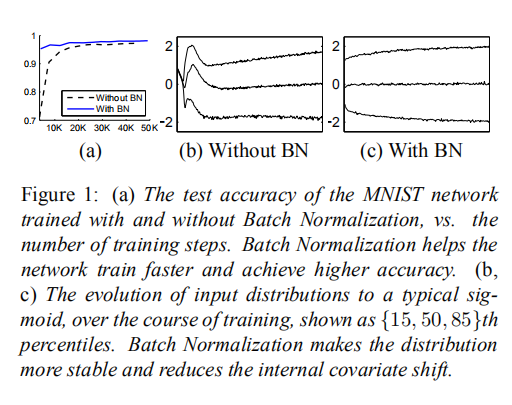

Figure 1(a) shows the fraction of correct predictions by the two networks on held-out test data, as training progresses. The batch-normalized network enjoys the higher test accuracy. To investigate why, we studied inputs to the sigmoid, in the original network N and batchnormalized network N tr BN (Alg. 2) over the course of training. In Fig. 1(b,c) we show, for one typical activation from the last hidden layer of each network, how its distribution evolves. The distributions in the original network change significantly over time, both in their mean and the variance, which complicates the training of the subsequent layers. In contrast, the distributions in the batchnormalized network are much more stable as training progresses, which aids the training.

图1(a)显示了随着训练的进展，两个网络对未交付测试数据的正确预测的比例。Batch Normalization网络具有较高的测试精度。为了探究原因，我们在训练过程中研究了原始网络N和batchnormalize网络N tr BN (Alg. 2)中sigmoid的输入。在图1(b,c)中，我们展示了每个网络最后一个隐含层的一个典型激活，它的分布是如何演变的。原始网络中分布的均值和方差随时间变化很大，这使后续层的训练变得复杂。相比之下，随训练的进行，Batch Normalization网络中的分布更加稳定，这有助于训练的进行。

## 4.2 ImageNet classification
## 4.2 ImageNet 分类

We applied Batch Normalization to a new variant of the Inception network, trained on the ImageNet classification task (Russakovsky et al., 2014). The network has a large number of convolutional and pooling layers, with a softmax layer to predict the image class, out of 1000 possibilities. Convolutional layers use ReLU as the nonlinearity. The main difference to the network described in (Szegedy et al., 2014) is that the 5 × 5 convolutional layers are replaced by two consecutive layers of 3 × 3 convolutions with up to 128 filters. The network contains 13.6 · 106 parameters, and, other than the top softmax layer, has no fully-connected layers. More details are given in the Appendix. We refer to this model as Inception in the rest of the text. The model was trained using a version of Stochastic Gradient Descent with momentum, using the mini-batch size of 32. The training was performed using a large-scale, distributed architecture . All networks are evaluated as training progresses by computing the validation accuracy @1, i.e. the probability of predicting the correct label out of 1000 possibilities, on a held-out set, using a single crop per image.

我们将批处理标准化应用于Inception网络的一个新变种，并在ImageNet分类任务上进行训练(Russakovsky et al.， 2014)。网络有大量的卷积和池化层，有一个softmax层来预测图像类，有1000种可能性。卷积层使用ReLU作为非线性。(Szegedy et al.， 2014)中描述的网络的主要区别是，5×5个卷积层被两个连续的3×3个卷积层替换，最多可达128个滤波器。该网络包含13.6·106个参数，除了顶层的softmax层之外，没有完全连接的层。更多的细节在附录中给出。在本文的其余部分中，我们将此模型称为Inception。该模型使用具有动量的随机梯度下降的版本进行训练，使用32个小批量。训练是使用大规模分布式架构进行的。通过计算验证精度@1(即在一张未售出的集合上，使用每张图像的单个裁剪来预测1000种可能性中的正确标签的概率)，所有网络都将作为训练进展进行评估。

In our experiments, we evaluated several modifications of Inception with Batch Normalization. In all cases, Batch Normalization was applied to the input of each nonlinearity, in a convolutional way, as described in section 3.2, while keeping the rest of the architecture constant.

在我们的实验中，我们用 Batch Normalization 评估了Inception的几个修改。在所有情况下，以卷积的方式对每个非线性的输入进行 Batch Normalization ，如第3.2节所述，同时保持其余的体系结构不变。

### 4.2.1 Accelerating BN Networks
### 4.2.1加速BN网络

Simply adding Batch Normalization to a network does not take full advantage of our method. To do so, we further changed the network and its training parameters, as follows:

简单地将 Batch Normalization 添加到网络并不能充分利用我们的方法。为此，我们进一步改变了网络及其训练参数，具体如下:

Increase learning rate. In a batch-normalized model, we have been able to achieve a training speedup from higher learning rates, with no ill side effects (Sec. 3.3).

提高学习速率。在 Batch Normalization 模型中，我们能够通过较高的学习速率实现训练加速，并且没有不良的副作用(第3.3节)。

Remove Dropout. As described in Sec. 3.4, Batch Normalization fulfills some of the same goals as Dropout. Removing Dropout from Modified BN-Inception speeds up training, without increasing overfitting.

删除Dropout。如第3.4节所述， Batch Normalization 实现了与Dropout相同的一些目标。在不增加过拟合的情况下，从修改的BN-Inception中移除Dropout可以加速训练。

Reduce the L2 weight regularization. While in Inception an L2 loss on the model parameters controls overfitting, in Modified BN-Inception the weight of this loss is reduced by a factor of 5. We find that this improves the accuracy on the held-out validation data.

减少L2权重的正规化。在初始阶段，模型参数的L2损失控制过拟合，而在修正的BN-Inception这种损失的权重减少了5倍。我们发现这提高了持有验证数据的准确性。

Accelerate the learning rate decay. In training Inception, learning rate was decayed exponentially. Because our network trains faster than Inception, we lower the learning rate 6 times faster.

加速学习速率衰减。在训练初期，学习率呈指数衰减。因为我们的网络训练速度比初始速度快，所以我们降低学习速度的速度是初始速度的6倍。

Remove Local Response Normalization While Inception and other networks (Srivastava et al., 2014) benefit from it, we found that with Batch Normalization it is not necessary.

当Inception和其他网络(Srivastava et al.， 2014)受益于它时，我们发现Batch Normalization是没有必要的。

Shuffle training examples more thoroughly. We enabled within-shard shuffling of the training data, which prevents the same examples from always appearing in a mini-batch together. This led to about 1% improvements in the validation accuracy, which is consistent with the view of Batch Normalization as a regularizer (Sec. 3.4): the randomization inherent in our method should be most beneficial when it affects an example differently each time it is seen.

乱序训练样本更彻底。我们启用了训练数据的分片内重组，这可以防止相同的示例总是出现在一个小批中。这使得验证精度提高了约1%，这与Batch Normalization作为正则化器的观点是一致的(第3.4节):我们的方法中固有的随机化应该是最有益的，当它每次对一个例子产生不同的影响时。

Reduce the photometric distortions. Because batchnormalized networks train faster and observe each training example fewer times, we let the trainer focus on more “real” images by distorting them less.

减少光度失真。因为Batch Normalization的网络训练速度更快，观察每个训练示例的次数更少，所以我们让训练器通过较少的失真来关注更多的“真实”图像。

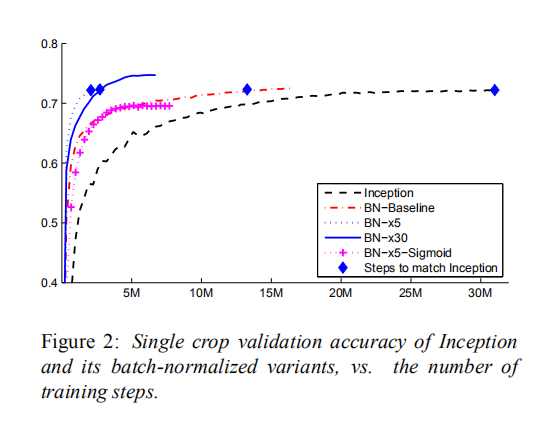


### 4.2.2  Single-Network Classification
### 4.2.2 单独的网络分类

We evaluated the following networks, all trained on the LSVRC2012 training data, and tested on the validation data:

我们评估了以下网络，均使用LSVRC2012训练数据进行训练，并使用验证数据进行测试:

Inception: the network described at the beginning of Section 4.2, trained with the initial learning rate of 0.0015.

初始:4.2节开始描述的网络，初始学习率为0.0015。

BN-Baseline: Same as Inception with Batch Normalization before each nonlinearity.

BN-Baseline:与初始化一样，在每个非线性之前进行Batch Normalization。

BN-x5: Inception with Batch Normalization and the modifications in Sec. 4.2.1. The initial learning rate was increased by a factor of 5, to 0.0075. The same learning rate increase with original Inception caused the model parameters to reach machine infinity.

BN-x5:Batch Normalization的初始化和4.2.1节中的修改。初始学习率提高了5倍，达到0.0075。同样的学习率随着初始时间的增加使得模型参数达到无穷大。

BN-x30: Like BN-x5, but with the initial learning rate 0.045 (30 times that of Inception).

BN-x30:与BN-x5类似，但初始学习率为0.045(初始时的30倍)。

BN-x5-Sigmoid: Like BN-x5, but with sigmoid nonlinearity g(t) = 1 / 1+exp(-x) instead of ReLU. We also attempted to train the original Inception with sigmoid, but the model remained at the accuracy equivalent to chance.

BN-x5- sigmoid:类似于BN-x5，但用sigmoid非线性函数g(t) = 1 / 1+exp(-x)代替ReLU。我们也尝试着用sigmoid训练最初的Inception，但是模型仍然保持着等同于偶然的准确性。

In Figure 2, we show the validation accuracy of the networks, as a function of the number of training steps. Inception reached the accuracy of 72.2% after 31 · 106 training steps. The Figure 3 shows, for each network, the number of training steps required to reach the same 72.2% accuracy, as well as the maximum validation accuracy reached by the network and the number of steps to reach it.

在图2中，我们展示了网络的验证准确性，作为训练步骤数量的函数。初始阶段，经过31·106个训练步骤，准确率达到72.2%。图3显示了对于每个网络，达到相同的72.2%的准确率所需要的训练步骤的数量，以及网络所达到的最大验证准确率和达到这个准确率所需要的步骤的数量。

By only using Batch Normalization (BN-Baseline), we match the accuracy of Inception in less than half the number of training steps. By applying the modifications in Sec. 4.2.1, we significantly increase the training speed of the network. BN-x5 needs 14 times fewer steps than Inception to reach the 72.2% accuracy. Interestingly, increasing the learning rate further (BN-x30) causes the model to train somewhat slower initially, but allows it to reach a higher final accuracy. It reaches 74.8% after 6·10^6 steps, i.e. 5 times fewer steps than required by Inception to reach 72.2%.

通过只使用Batch Normalization(BN-Baseline)，我们在不到一半的训练步骤中匹配初始化的准确性。通过应用第4.2.1节中的修改，我们显著提高了网络的训练速度。BN-x5需要比Inception少14倍的步骤才能达到72.2%的准确率。有趣的是，进一步增加学习率(BN-x30)会使模型最初的训练稍微慢一些，但允许它达到更高的最终精度。6·10^6步后达到74.8%，比初始所需的步骤少5倍，达到72.2%。

We also verified that the reduction in internal covariate shift allows deep networks with Batch Normalization to be trained when sigmoid is used as the nonlinearity, despite the well-known difficulty of training such networks. Indeed, BN-x5-Sigmoid achieves the accuracy of 69.8%. Without Batch Normalization, Inception with sigmoid never achieves better than 1/1000 accuracy.

我们还验证了内部协变量移位的减少使得使用sigmoid作为非线性时可以训练具有批Batch Normalization的深度网络，尽管这种网络的训练难度众所周知。事实上，BN-x5-Sigmoid的准确率达到了69.8%。如果没有Batch Normalization，先启时使用sigmoid的准确率永远不会超过1/1000。

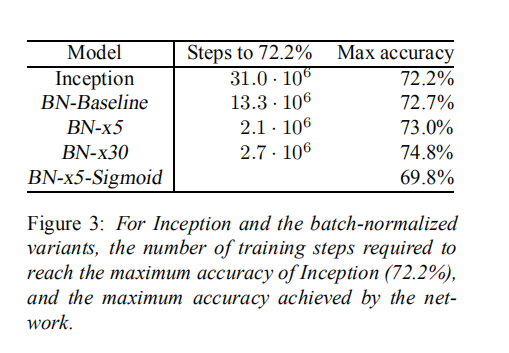


### 4.2.3 Ensemble Classification
### 4.2.3 集成分类

The current reported best results on the ImageNet Large Scale Visual Recognition Competition are reached by the Deep Image ensemble of traditional models and the ensemble model of (He et al., 2015). The latter reports the top-5 error of 4.94%, as evaluated by the ILSVRC server. Here we report a top-5 validation error of 4.9%, and test error of 4.82% (according to the ILSVRC server). This improves upon the previous best result, and exceeds the estimated accuracy of human raters according to (Russakovsky et al., 2014).

目前报道的ImageNet大型视觉识别竞赛的最佳结果是通过传统模型的深度图像集成和(He et al.， 2015)的集成模型得到的。根据ILSVRC服务器的评估，后者报告的前5位错误为4.94%。在这里，我们报告前5名的验证错误为4.9%，测试错误为4.82%(根据ILSVRC服务器)。这改进了之前的最佳结果，并超过了人类评分者的估计精度(Russakovsky et al.， 2014)。

For our ensemble, we used 6 networks. Each was based on BN-x30, modified via some of the following: increased initial weights in the convolutional layers; using Dropout (with the Dropout probability of 5% or 10%, vs. 40% for the original Inception); and using non-convolutional, per-activation Batch Normalization with last hidden layers of the model. Each network achieved its maximum accuracy after about 6 · 10^6 training steps. The ensemble prediction was based on the arithmetic average of class probabilities predicted by the constituent networks. The details of ensemble and multicrop inference are similar to (Szegedy et al., 2014).

在我们的集成中，我们使用了6个网络。每一个都基于BN-x30，并通过以下修改:增加了卷积层的初始权重;使用Dropout(退出的概率为5%或10%，而最初的初始为40%);并使用非卷积的、每次激活的批处理与模型的最后隐藏层进行归一化。每个网络经过约6·10^6个训练步骤后，达到其最大精度。集成预测是基于各组成网络预测的类概率的算术平均。集成和多rop推理的细节类似于(Szegedy et al.， 2014)。

We demonstrate in Fig. 4 that batch normalization allows us to set new state-of-the-art by a healthy margin on the ImageNet classification challenge benchmarks.

我们在图4中演示了Batch Normalization允许我们在ImageNet分类挑战基准获得了SOTA依靠健康的边界。

# 5 Conclusion
# 5 结论

We have presented a novel mechanism for dramatically accelerating the training of deep networks. It is based on the premise that covariate shift, which is known to complicate the training of machine learning systems, also applies to sub-networks and layers, and removing it from internal activations of the network may aid in training. Our proposed method draws its power from normalizing activations, and from incorporating this normalization in the network architecture itself. This ensures that the normalization is appropriately handled by any optimization method that is being used to train the network. To enable stochastic optimization methods commonly used in deep network training, we perform the normalization for each mini-batch, and backpropagate the gradients through the normalization parameters. Batch Normalization adds only two extra parameters per activation, and in doing so preserves the representation ability of the network. We presented an algorithm for constructing, training, and performing inference with batch-normalized networks. The resulting networks can be trained with saturating nonlinearities, are more tolerant to increased training rates, and often do not require Dropout for regularization.

我们提出了一种新的机制来显著加快深度网络的训练。它的前提是协变移位(covariate shift)也适用于子网络和层，将其从网络的内部激活中去除可能有助于训练。协变移位已知会使机器学习系统的训练复杂化。我们所提出的方法的强大之处在于对激活进行规范化，并将这种规范化融入到网络体系结构中。这可以确保任何用于训练网络的优化方法都能适当地Batch Normalization。为了实现深度网络训练中常用的随机优化方法，我们对每个小批量进行归一化，并通过归一化参数对梯度进行反向传播。Batch Normalization在每次激活时只增加两个额外的参数，这样做保留了网络的表示能力。我们提出了一种利用Batch Normalization网络构造、训练和执行推理的算法。得到的网络可以用饱和非线性进行训练，对增加的训练率有更大的容忍度，而且通常不需要Dropout为正则化。

Merely adding Batch Normalization to a state-of-theart image classification model yields a substantial speedup in training. By further increasing the learning rates, removing Dropout, and applying other modifications afforded by Batch Normalization, we reach the previous state of the art with only a small fraction of training steps and then beat the state of the art in single-network image classification. Furthermore, by combining multiple models trained with Batch Normalization, we perform better than the best known system on ImageNet, by a significant margin.

仅仅在最先进的图像分类模型中添加Batch Normalization，就可以显著提高训练的速度。通过进一步提高学习速率，去除Dropout，并应用Batch Normalization所提供的其他修改，我们只需要很少的训练步骤就可以达到之前的水平，然后在单网络图像分类中击败目前的水平。此外，通过将多个经过训练的模型与Batch Normalization相结合，我们的性能比ImageNet上最著名的系统要好得多。

Interestingly, our method bears similarity to the standardization layer of (G¨ulc¸ehre & Bengio, 2013), though the two methods stem from very different goals, and perform different tasks. The goal of Batch Normalization is to achieve a stable distribution of activation values throughout training, and in our experiments we apply it before the nonlinearity since that is where matching the first and second moments is more likely to result in a stable distribution. On the contrary, (G¨ulc¸ehre & Bengio, 2013) apply the standardization layer to the output of the nonlinearity, which results in sparser activations. In our large-scale image classification experiments, we have not observed the nonlinearity inputs to be sparse, neither with nor without Batch Normalization. Other notable differentiating characteristics of Batch Normalization include the learned scale and shift that allow the BN transform to represent identity (the standardization layer did not require this since it was followed by the learned linear transform that, conceptually, absorbs the necessary scale and shift), handling of convolutional layers, deterministic inference that does not depend on the mini-batch, and batchnormalizing each convolutional layer in the network.

有趣的是，我们的方法与(G¨ulc ehre & Bengio, 2013)的标准化层具有相似性，尽管这两种方法源于非常不同的目标，执行不同的任务。Batch Normalization的目标是在整个训练过程中实现激活值的稳定分布，在我们的实验中，我们将其应用于非线性之前，因为在非线性之前匹配第一和第二矩更有可能得到稳定的分布。相反，(G¨ulc ehre & Bengio, 2013)将标准化层应用于非线性的输出，导致更稀疏的激活。在我们的大规模图像分类实验中，我们没有观察到非线性输入是稀疏的，没有Batch Normalization也没有。批正常化的其他显著的差异化特征包括规模和学习转变,使BN变换代表身份(标准化层不需要这个,因为随之而来的线性变换,从概念上讲,吸收必要的规模和转移),卷积处理层,确定性推理,并不取决于mini-batch,和每个卷积batchnormalizing层网络中。

In this work, we have not explored the full range of possibilities that Batch Normalization potentially enables. Our future work includes applications of our method to Recurrent Neural Networks (Pascanu et al., 2013), where the internal covariate shift and the vanishing or exploding gradients may be especially severe, and which would allow us to more thoroughly test the hypothesis that normalization improves gradient propagation (Sec. 3.3). We plan to investigate whether Batch Normalization can help with domain adaptation, in its traditional sense – i.e. whether the normalization performed by the network would allow it to more easily generalize to new data distributions, perhaps with just a recomputation of the population means and variances (Alg. 2). Finally, we believe that further theoretical analysis of the algorithm would allow still more improvements and applications.

在这项工作中，我们没有探索Batch Normalization可能带来的全部可能性。我们未来的工作包括将我们的方法应用于递归神经网络(Pascanu et al.， 2013)，其中内部协变量移位和消失或爆炸梯度可能特别严重，这将使我们能够更彻底地测试正常化改善梯度传播的假设(第3.3节)。我们计划调查是否Batch Normalization有助于领域适应变化,在传统意义上,即标准化执行的网络是否会使它更容易推广到新的数据分布,也许只有一个人口的重新计算均值和方差(Alg。2)。最后,我们相信的进一步理论分析算法将允许更多的改进和应用。

